In [1]:
import pandas as pd
import numpy as np
from yahoo_fin import stock_info as si
from datetime import datetime

# Define the symbol, start date, and end date
ticker = 'AAPL'  # yahoo ticker
StartDate = datetime(2023, 1,1)

# Fetch historical stock data
StockData = si.get_data(ticker, start_date=StartDate)

# Check the shape of the data
print(StockData.shape)

StockData.tail()
# Display the first 10 rows of the data
#StockData.to_csv('data.csv', index=True)

(347, 7)


,open,high,low,close,adjclose,volume,ticker
2024-05-14,187.509995,188.300003,186.289993,187.429993,187.429993,52393600,AAPL
2024-05-15,187.910004,190.649994,187.369995,189.720001,189.720001,70400000,AAPL
2024-05-16,190.470001,191.100006,189.660004,189.839996,189.839996,52845200,AAPL
2024-05-17,189.509995,190.809998,189.179993,189.869995,189.869995,41282900,AAPL
2024-05-20,189.330002,191.919998,189.009995,191.039993,191.039993,44323200,AAPL


<Axes: xlabel='TradeDate'>

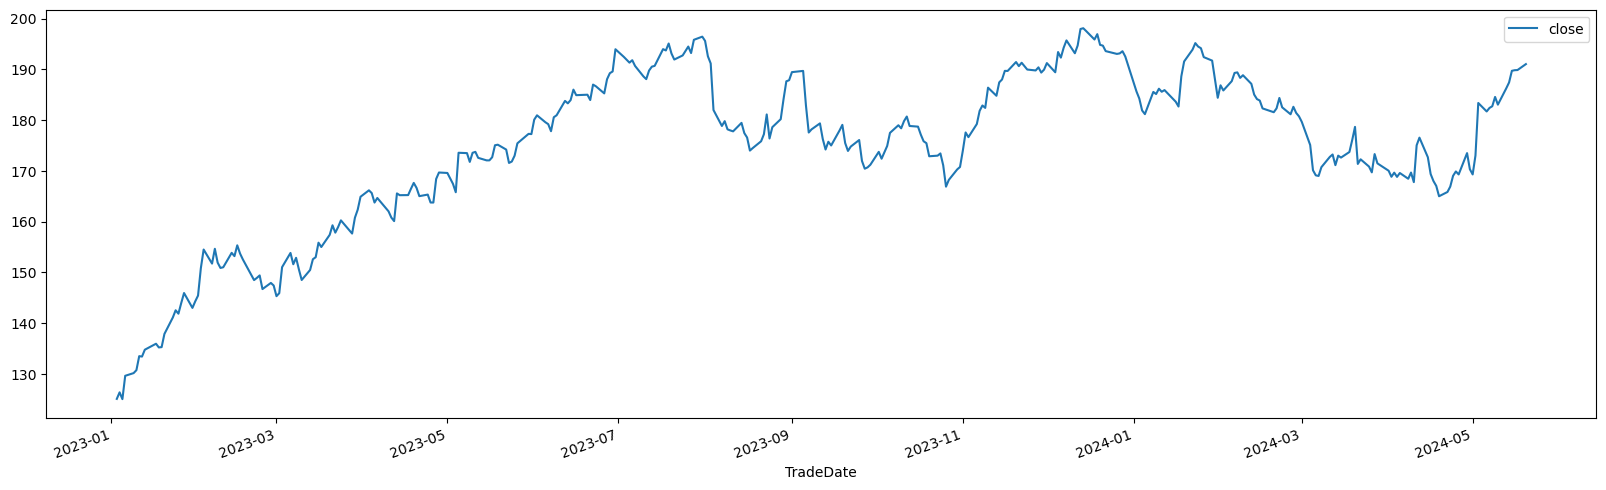

In [2]:
# Creating a column as date
StockData['TradeDate']=StockData.index
# Plotting the stock prices
StockData.plot(x='TradeDate', y='close', kind='line', figsize=(20,6), rot=20)

In [3]:
# Extracting the closing prices of each day
FullData=StockData[['close']].values
print(FullData[0:5])
 
# Feature Scaling for fast training of neural networks
from sklearn.preprocessing import StandardScaler, MinMaxScaler
 
# Choosing between Standardization or normalization
#sc = StandardScaler()
sc=MinMaxScaler()
 
DataScaler = sc.fit(FullData)
X=DataScaler.transform(FullData)
#X=FullData
 
print('### After Normalization ###')
X[0:5]

[[125.06999969]
 [126.36000061]
 [125.01999664]
 [129.61999512]
 [130.1499939 ]]
### After Normalization ###


array([[0.00068413],
       [0.01833361],
       [0.        ],
       [0.06293608],
       [0.0701874 ]])

In [4]:
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next day's Price Prediction is based on last how many past day's prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
# Reshape the Input as a 3D (number of samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('\n#### Input Data shape ####')
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
y_data=y_data.reshape(y_data.shape[0], 1)
print('\n#### Output Data shape ####')
print(y_data.shape)


#### Input Data shape ####
(337, 10, 1)

#### Output Data shape ####
(337, 1)


In [5]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
############################################
 
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(332, 10, 1)
(332, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 1)


In [6]:
# Visualizing the input and output being sent to the LSTM model
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp,'--', out)

[[0.00068413]
 [0.01833361]
 [0.        ]
 [0.06293608]
 [0.0701874 ]
 [0.07812285]
 [0.11588464]
 [0.11479007]
 [0.13326033]
 [0.14940491]] -- [0.13941729]
[[0.01833361]
 [0.        ]
 [0.06293608]
 [0.0701874 ]
 [0.07812285]
 [0.11588464]
 [0.11479007]
 [0.13326033]
 [0.14940491]
 [0.13941729]] -- [0.14023816]


In [7]:
# Defining Input shapes for LSTM
TimeSteps=X_train.shape[1]
TotalFeatures=X_train.shape[2]
print("Number of TimeSteps:", TimeSteps)
print("Number of Features:", TotalFeatures)

Number of TimeSteps: 10
Number of Features: 1


In [8]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, InputLayer
 
# Initialising the RNN
regressor = Sequential()
 
# Adding the First input hidden layer and the LSTM layer
# return_sequences = True, means the output of every time step to be shared with hidden next layer
regressor.add(InputLayer(shape = (TimeSteps, TotalFeatures)))
regressor.add(LSTM(units = 10, activation = 'relu', return_sequences=True))

# Adding the Second Second hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=True))

# Adding the Second Third hidden layer and the LSTM layer
regressor.add(LSTM(units = 5, activation = 'relu', return_sequences=False ))
 
 
# Adding the output layer
regressor.add(Dense(units = 1))
 
# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
 
##################################################
 
import time
# Measuring the time taken by the model to train
StartTime=time.time()
 
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, batch_size = 5, epochs = 100)

EndTime=time.time()
print("## Total Time Taken: ", round((EndTime-StartTime)/60), 'Minutes ##')

Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4539
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0926
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0063
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0043
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0042
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0044
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0044
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047
Epoch 13/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 14/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 15/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0039
Epoc

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
Accuracy: 98.97346405282266


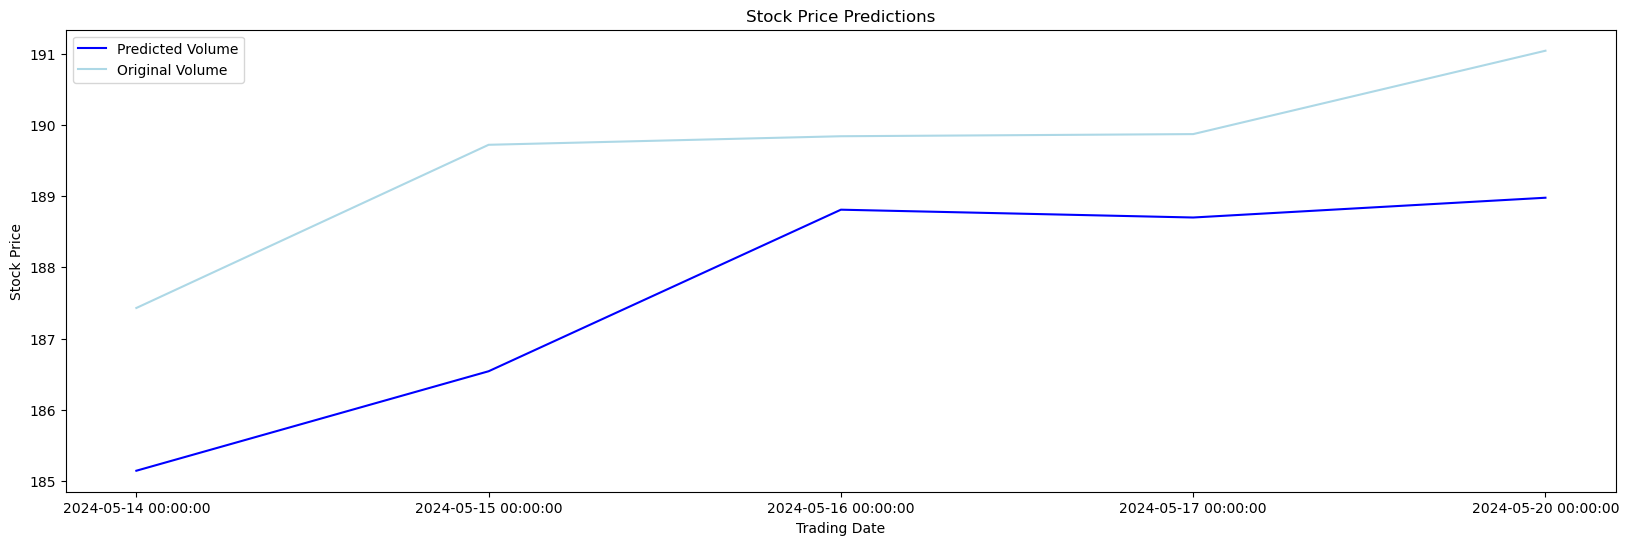

In [9]:
# Making predictions on test data
predicted_Price = regressor.predict(X_test)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
 
# Getting the original price values for testing data
orig=y_test
orig=DataScaler.inverse_transform(y_test)
 
# Accuracy of the predictions
print('Accuracy:', 100 - (100*(abs(orig-predicted_Price)/orig)).mean())
 
# Visualising the results
import matplotlib.pyplot as plt
 
plt.plot(predicted_Price, color = 'blue', label = 'Predicted Volume')
plt.plot(orig, color = 'lightblue', label = 'Original Volume')
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.xticks(range(TestingRecords), StockData.tail(TestingRecords)['TradeDate'])
plt.ylabel('Stock Price')
 
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(6)
plt.show()

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


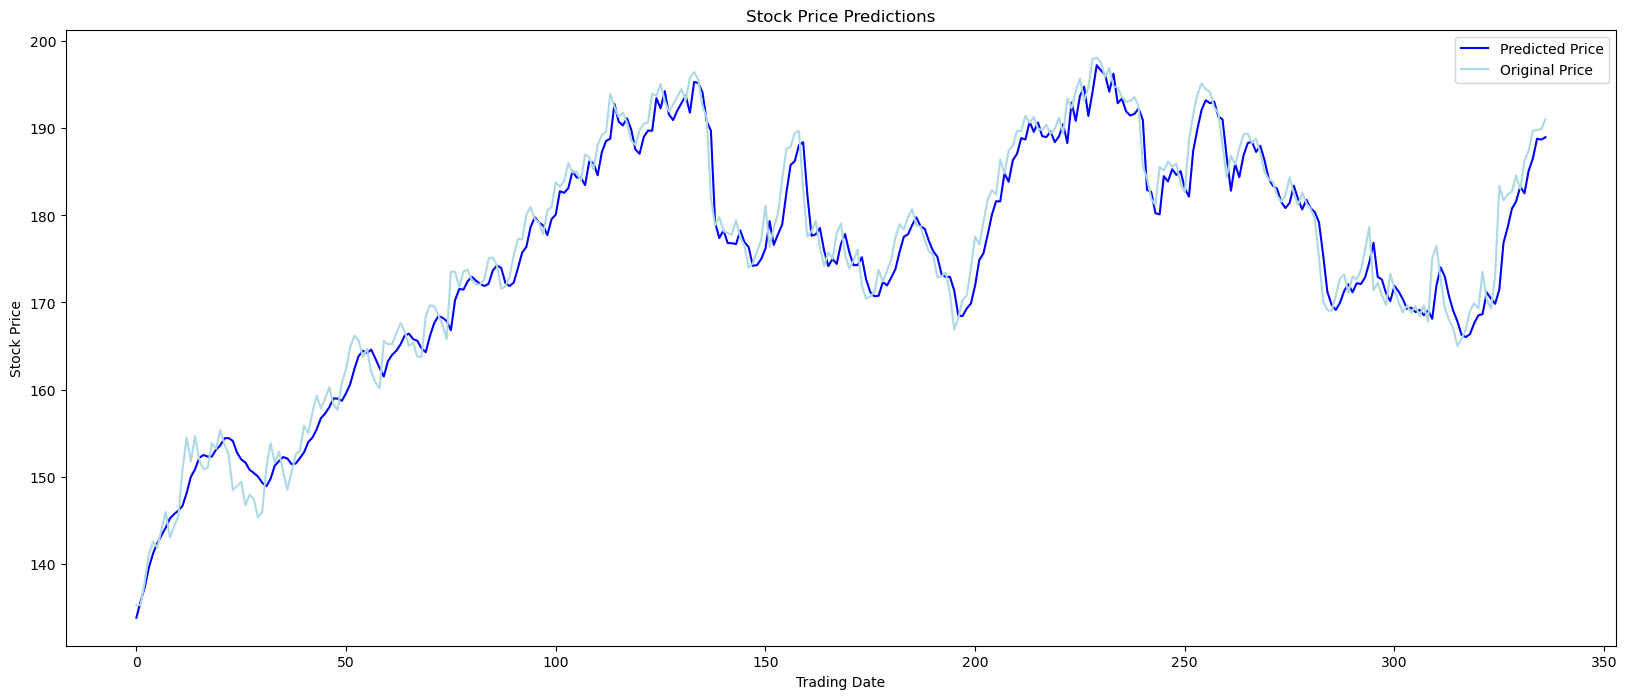

In [10]:
# Generating predictions on full data
TrainPredictions=DataScaler.inverse_transform(regressor.predict(X_train))
TestPredictions=DataScaler.inverse_transform(regressor.predict(X_test))
 
FullDataPredictions=np.append(TrainPredictions, TestPredictions)
FullDataOrig=FullData[TimeSteps:]
 
# plotting the full data
plt.plot(FullDataPredictions, color = 'blue', label = 'Predicted Price')
plt.plot(FullDataOrig , color = 'lightblue', label = 'Original Price')
 
 
plt.title('Stock Price Predictions')
plt.xlabel('Trading Date')
plt.ylabel('Stock Price')
plt.legend()
fig=plt.gcf()
fig.set_figwidth(20)
fig.set_figheight(8)
plt.show()

In [11]:
# Last 10 days prices
Last10Days = np.array(FullData[-10:])

# Normalizing the data just like we did for training the model
Last10Days=DataScaler.transform(Last10Days.reshape(-1,1))
 
# Changing the shape of the data to 3D
# Choosing TimeSteps as 10 because we have used the same for training
NumSamples=1
TimeSteps=10
NumFeatures=1
Last10Days=Last10Days.reshape(NumSamples,TimeSteps,NumFeatures)
 
#############################
 
# Making predictions on data
predicted_Price = regressor.predict(Last10Days)
predicted_Price = DataScaler.inverse_transform(predicted_Price)
predicted_Price

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


array([[190.35085]], dtype=float32)

In [12]:
# Multi step data preparation
 
# split into samples
X_samples = list()
y_samples = list()
 
NumerOfRows = len(X)
TimeSteps=10  # next few day's Price Prediction is based on last how many past day's prices
FutureTimeSteps=5 # How many days in future you want to predict the prices
 
# Iterate thru the values to create combinations
for i in range(TimeSteps , NumerOfRows-FutureTimeSteps , 1):
    x_sample = X[i-TimeSteps:i]
    y_sample = X[i:i+FutureTimeSteps]
    X_samples.append(x_sample)
    y_samples.append(y_sample)
 
################################################
 
# Reshape the Input as a 3D (samples, Time Steps, Features)
X_data=np.array(X_samples)
X_data=X_data.reshape(X_data.shape[0],X_data.shape[1], 1)
print('### Input Data Shape ###') 
print(X_data.shape)
 
# We do not reshape y as a 3D data  as it is supposed to be a single column only
y_data=np.array(y_samples)
print('### Output Data Shape ###') 
print(y_data.shape)

### Input Data Shape ###
(332, 10, 1)
### Output Data Shape ###
(332, 5, 1)


In [13]:
# Choosing the number of testing data records
TestingRecords=5
 
# Splitting the data into train and test
X_train=X_data[:-TestingRecords]
X_test=X_data[-TestingRecords:]
y_train=y_data[:-TestingRecords]
y_test=y_data[-TestingRecords:]
 
#############################################
# Printing the shape of training and testing
print('\n#### Training Data shape ####')
print(X_train.shape)
print(y_train.shape)
 
print('\n#### Testing Data shape ####')
print(X_test.shape)
print(y_test.shape)


#### Training Data shape ####
(327, 10, 1)
(327, 5, 1)

#### Testing Data shape ####
(5, 10, 1)
(5, 5, 1)


In [14]:
# Visualizing the input and output being sent to the LSTM model
# Based on last 10 days prices we are learning the next 5 days of prices
for inp, out in zip(X_train[0:2], y_train[0:2]):
    print(inp)
    print('====>')
    print(out)
    print('#'*20)

[[0.00068413]
 [0.01833361]
 [0.        ]
 [0.06293608]
 [0.0701874 ]
 [0.07812285]
 [0.11588464]
 [0.11479007]
 [0.13326033]
 [0.14940491]]
====>
[[0.13941729]
 [0.14023816]
 [0.17581061]
 [0.2201396 ]
 [0.23956767]]
####################
[[0.01833361]
 [0.        ]
 [0.06293608]
 [0.0701874 ]
 [0.07812285]
 [0.11588464]
 [0.11479007]
 [0.13326033]
 [0.14940491]
 [0.13941729]]
====>
[[0.14023816]
 [0.17581061]
 [0.2201396 ]
 [0.23956767]
 [0.23040092]]
####################
